# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [2]:
df = pd.read_csv('taxi2.csv')

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df = df.set_index('datetime')

Ресемплирование по одному часу

In [6]:
df = df.resample('1H').sum()

In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Осмотр данных

# 2. Анализ

Построение графика со скользящими стандартным отклонением и средним

In [8]:
data = df
data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()
data['std'] = data['num_orders'].rolling(12).std()

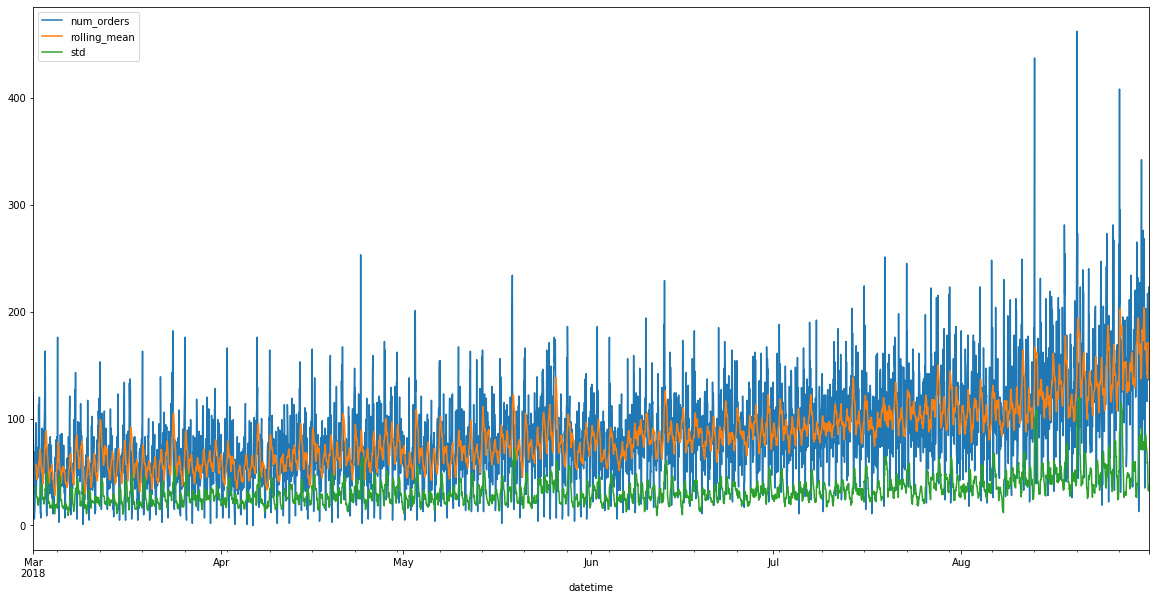

In [9]:
data.plot(figsize=([20,10]))

#### Вывод: 
- исходя из графика, можно сделать вывод, что среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный

# 3. Обучение и тестирование моделей

Создание признаков

In [10]:
def make_features(data, max_lag, size_1):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    #косинусно-синусное преобразование времени для отображения циклического характера часов
    data['s_hour'] = np.sin(2*np.pi*data['hour']/24)
    data['c_hour'] = np.cos(2*np.pi*data['hour']/24)
    
    #время суток
    data['night'] = (data['hour'].isin([23, 0, 1, 2, 3, 4])).astype(np.int32)
    data['morning'] = (data['hour'].isin([5, 6, 7, 8])).astype(np.int32)
    data['daytime'] = (data['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16, 17])).astype(np.int32)
    data['evening'] = (data['hour'].isin([18, 19, 20, 21, 22])).astype(np.int32)
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    #отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    #скользящее среднее
    data['rolling_mean_1'] = data['num_orders'].shift().rolling(size_1).mean()
    
    #data['rolling_mean_2'] = data['num_orders'].shift().rolling(size_2).mean()
    #data['rolling_mean_3'] = data['num_orders'].shift().rolling(size_3).mean()
    
    #скользящее стандартное отклонение
    data['std_1'] = data['num_orders'].rolling(size_1).std()
    
    #data['std_2'] = data['num_orders'].rolling(size_2).std()

    #data['std_3'] = data['num_orders'].rolling(size_3).std()
    
    data.dropna(inplace=True)
    
    #тренд
    decomposed = seasonal_decompose(data['num_orders'], freq = 24)
    data['trend'] = decomposed.trend
    data['seasonal'] = decomposed.seasonal
    data.dropna(inplace=True)

In [11]:
make_features(df, 24, 24)

Создание переменных для признаков и целевого признака

In [12]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

Разделение датасета на обучающую и тестовую выборки в соотношении 9:1

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

Кросс-валидация на скользящем окне для временного ряда, которая будет использоваться в дальнейшем

In [14]:
tscv = TimeSeriesSplit(n_splits=5)

#### Случайный лес 

Для `RandomForestRegressor` поиск будет осуществляться по гиперпараметрам `max_depth`, `min_samples_split`. Создаю переменную `tree_params` c различными вариантами значений указанных гиперпараметров.

In [15]:
tree_params = {'max_depth': [12, 14, 16, 18],
               'min_samples_split': [2, 3, 4, 6]}

In [16]:
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=42), 
                        tree_params, refit=False, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_rfr.fit(X_train, y_train)
params = grid_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state = 42)
rfr.fit(X_train, y_train)
pred_test = rfr.predict(X_test)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

{'max_depth': 18, 'min_samples_split': 6}
RMSE на тестовой выборке:  40.53331772442355


#### Градиентный бустинг

Для `LGBMRegressor` поиск будет осуществляться по гиперпараметрам `max_depth`, `num_leaves`, `learning_rate`. Создаю переменную `param_grid` c различными вариантами значений указанных гиперпараметров.

In [17]:
param_grid = {
    'n_estimators': [1000], 
    'learning_rate': [0.015, 0.02, 0.035, 0.15],
    'max_depth': [8, 10, 12, 14],
    'num_leaves': [6, 12, 25, 50]
}

In [19]:
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=42), 
                    param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', refit=False) 
grid_lgbm.fit(X_train, y_train)
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state = 42)
lgbm.fit(X_train, y_train)
pred_test = lgbm.predict(X_test)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

{'learning_rate': 0.015, 'max_depth': 12, 'n_estimators': 1000, 'num_leaves': 12}
RMSE на тестовой выборке:  38.283565531032416


#### Линейная регрессия

In [23]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=tscv)
grid_lr.fit(X_train, y_train)
params = grid_lr.best_params_
lr = LinearRegression(**params)
lr.fit(X_train, y_train)
pred_test = lr.predict(X_test)
print(params)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, pred_test) ** 0.5)

{'copy_X': True, 'fit_intercept': False, 'normalize': True}
RMSE на тестовой выборке:  39.64963283121908


### Вывод:
- На тестовой выборке лучшее значение RMSE 38.3 удалось достичь, используя `LGBMRegressor`. Результат `LinearRegression` чуть меньше - 39.6. Самый худший результат 40.5 показал `RandomForestRegressor`.